# Setup

In [1]:
# import your standard packages
%run ../pkgs.py
%run ../pars.py

# import your local functions
sys.path.insert(1, '../../code/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline


Default libraries loaded.


# Paths and Parameters

In [2]:
outfn = '../../data/sla_to_woa.nc'

ds_out = xr.Dataset()

# Read Data

In [3]:
# SLA
ds_SLA = xr.open_dataset('../../data/sla_processed.nc')
ds_SLA

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 6, lon: 216, month: 12, no_stations: 495, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 493.0 494.0 495.0
  * loc_list          (loc_list) int64 0 75 225 294 415 494
Data variables:
    daily_sla         (day_time, lat, lon) float64 ...
    mon_sla           (time, lat, lon) float64 ...
    mon_sla_mon_clim  (month, lat, lon) float64 ...
    mon_sla_mon_anom  (time, lat, lon) float64 ...
    sta_loninds       (no_stations) int64 ...
    sta_latinds       (no_stations) int64 ...
    sta_lon           (no_sta

In [4]:
# WOA
infn_WOA = '../../data/woa_processed.nc'

ds_WOA = xr.open_dataset(infn_WOA)
# ds_WOA

In [5]:
ds_mask = xr.open_dataset('../../data/coastal_mask.nc')
ds_mask

<xarray.Dataset>
Dimensions:         (lat: 138, lat_ro: 138, lat_woa: 35, loc_wod: 314731, loc_wod18: 301299, lon: 226, lon_ro: 216, lon_woa: 55)
Coordinates:
  * lat             (lat) float64 -1.5 -1.25 -1.0 -0.75 ... 32.25 32.5 32.75
  * lon             (lon) float64 48.5 48.75 49.0 49.25 ... 104.2 104.5 104.8
  * lat_ro          (lat_ro) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * lon_ro          (lon_ro) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat_woa         (lat_woa) float32 -1.5 -0.5 0.5 1.5 ... 29.5 30.5 31.5 32.5
  * lon_woa         (lon_woa) float32 48.5 49.5 50.5 51.5 ... 100.5 101.5 102.5
  * loc_wod         (loc_wod) int64 0 1 2 3 4 ... 314727 314728 314729 314730
  * loc_wod18       (loc_wod18) int64 0 1 2 3 4 ... 301295 301296 301297 301298
Data variables:
    maskw           (lat, lon) float64 ...
    maskw_ro        (lat_ro, lon_ro) int64 ...
    maskn           (lat, lon) float64 ...
    maskw_woa       (lat_woa, lon_woa) bool ...
    maskw_ro_w

# Regrid

In [6]:
xx,yy = np.meshgrid(ds_SLA.lon,ds_SLA.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_WOA,yy_WOA = np.meshgrid(ds_WOA.lon,ds_WOA.lat)

mon_sla_mon_clim_WOA = np.zeros((len(ds_WOA.month),len(ds_WOA.lat),len(ds_WOA.lon)))*np.nan

for tt in tqdm(range(len(ds_WOA.month))):

    temp_sla = np.array(ds_SLA.mon_sla_mon_clim[tt,:,:])

    # find the lons and lats of TCD vals at this time

    points = np.array( (xx,yy) ).T
    temp_values = temp_sla.flatten()

    mon_sla_mon_clim_WOA[tt,:,:] = griddata(points, temp_values, (xx_WOA,yy_WOA) ,method='linear')

# ds_out = xr.Dataset(coords={'month': ds_WOA.month,
#                         'lon': ds_WOA.lon,
#                         'lat': ds_WOA.lat})
coords = [ds_WOA.month,ds_WOA.lat,ds_WOA.lon]
dims = ['month','lat','lon']

# add to dataset
ds_out['mon_sla_mon_clim'] = xr.DataArray(mon_sla_mon_clim_WOA,dims = dims,coords = coords)



100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


# Sample Plot

Text(0.5, 1.0, 'Original')

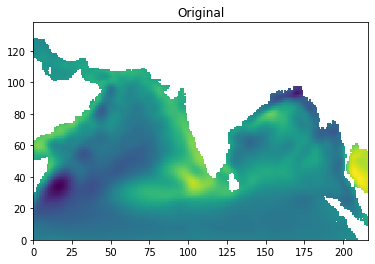

In [7]:
plt.pcolor(ds_SLA.mon_sla_mon_clim[0,:,:])
plt.title('Original')

Text(0.5, 1.0, 'Regridded')

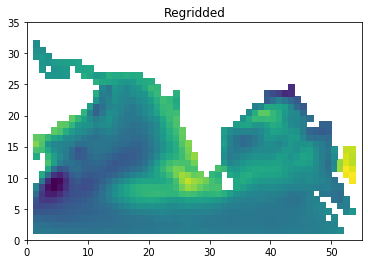

In [8]:
plt.pcolor(ds_out.mon_sla_mon_clim[0,:,:])
plt.title('Regridded')

# Convert to Coastal

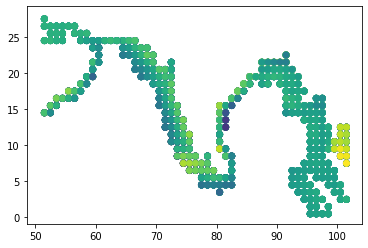

In [9]:
sla = ds_out.mon_sla_mon_clim

#############################################################
#----------------- Western Arabian Sea ---------------------#
#############################################################
lat_slice_wAS = slice(bounds_wAS[2],bounds_wAS[3]) 
lon_slice_wAS = slice(bounds_wAS[0],bounds_wAS[1]) 

#subset gridded data
sla_wAS = sla.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
mask_wAS = np.array(ds_mask.maskn_woa.sel(lat_woa = lat_slice_wAS, lon_woa = lon_slice_wAS)).flatten()

xx,yy = np.meshgrid(np.array(sla_wAS.lon),np.array(sla_wAS.lat))
xx_wAS = xx.flatten()
yy_wAS = yy.flatten()

sla_wAS = sla_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
xx_wAS = xx_wAS[mask_wAS]
yy_wAS = yy_wAS[mask_wAS]

mon_wAS = np.full(sla_wAS.shape,np.nan)
lat_wAS = np.full(sla_wAS.shape,np.nan)
lon_wAS = np.full(sla_wAS.shape,np.nan)
for tt in range(1,13):
    mon_wAS[tt-1,:] = np.ones([1,sla_wAS.shape[1]])*tt
    lat_wAS[tt-1,:] = yy_wAS
    lon_wAS[tt-1,:] = xx_wAS
    
sla_wAS = np.array(sla_wAS).flatten()
mon_wAS = np.array(mon_wAS).flatten()
lat_wAS = np.array(lat_wAS).flatten()
lon_wAS = np.array(lon_wAS).flatten()

#############################################################
#----------------- Eastern Arabian Sea ---------------------#
#############################################################

lat_slice_eAS = slice(bounds_eAS[2],bounds_eAS[3]) 
lon_slice_eAS = slice(bounds_eAS[0],bounds_eAS[1]) 

#subset gridded data
sla_eAS = sla.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
mask_eAS = np.array(ds_mask.maskw_ro_woa.sel(lat_woa = lat_slice_eAS, lon_woa = lon_slice_eAS)).flatten()

# convert to coastal
xx,yy = np.meshgrid(np.array(sla_eAS.lon),np.array(sla_eAS.lat))
xx_eAS = xx.flatten()
yy_eAS = yy.flatten()

sla_eAS = sla_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
xx_eAS = xx_eAS[mask_eAS]
yy_eAS = yy_eAS[mask_eAS]

mon_eAS = np.full(sla_eAS.shape,np.nan)
lat_eAS = np.full(sla_eAS.shape,np.nan)
lon_eAS = np.full(sla_eAS.shape,np.nan)
for tt in range(1,13):
    mon_eAS[tt-1,:] = np.ones([1,sla_eAS.shape[1]])*tt
    lat_eAS[tt-1,:] = yy_eAS
    lon_eAS[tt-1,:] = xx_eAS
    
sla_eAS = np.array(sla_eAS).flatten()
mon_eAS = np.array(mon_eAS).flatten()
lat_eAS = np.array(lat_eAS).flatten()
lon_eAS = np.array(lon_eAS).flatten()

# SL area --------------------------------------------------#
lat_slice_eAS_SL = slice(bounds_eAS_SL[2],bounds_eAS_SL[3]) 
lon_slice_eAS_SL = slice(bounds_eAS_SL[0],bounds_eAS_SL[1]) 

#subset gridded data
sla_eAS_SL = sla.sel(lat = lat_slice_eAS_SL, lon = lon_slice_eAS_SL)
mask_eAS_SL = np.array(ds_mask.maskw_ro_woa.sel(lat_woa = lat_slice_eAS_SL, 
                                                lon_woa = lon_slice_eAS_SL)).flatten()

# convert to coastal
xx,yy = np.meshgrid(np.array(sla_eAS_SL.lon),np.array(sla_eAS_SL.lat))
xx_eAS_SL = xx.flatten()
yy_eAS_SL = yy.flatten()

sla_eAS_SL = sla_eAS_SL.stack(allpoints=['lat','lon'])[:,mask_eAS_SL]
xx_eAS_SL = xx_eAS_SL[mask_eAS_SL]
yy_eAS_SL = yy_eAS_SL[mask_eAS_SL]

mon_eAS_SL = np.full(sla_eAS_SL.shape,np.nan)
lat_eAS_SL = np.full(sla_eAS_SL.shape,np.nan)
lon_eAS_SL = np.full(sla_eAS_SL.shape,np.nan)
for tt in range(1,13):
    mon_eAS_SL[tt-1,:] = np.ones([1,sla_eAS_SL.shape[1]])*tt
    lat_eAS_SL[tt-1,:] = yy_eAS_SL
    lon_eAS_SL[tt-1,:] = xx_eAS_SL
    
sla_eAS_SL = np.array(sla_eAS_SL).flatten()
mon_eAS_SL = np.array(mon_eAS_SL).flatten()
lat_eAS_SL = np.array(lat_eAS_SL).flatten()
lon_eAS_SL = np.array(lon_eAS_SL).flatten()

# combine
sla_eAS = np.concatenate((sla_eAS,sla_eAS_SL),0)
mon_eAS = np.concatenate((mon_eAS,mon_eAS_SL),0)
lat_eAS = np.concatenate((lat_eAS,lat_eAS_SL),0)
lon_eAS = np.concatenate((lon_eAS,lon_eAS_SL),0)

#############################################################
#---------------- Western Bay of Bengal --------------------#
#############################################################

lat_slice_wBoB = slice(bounds_wBoB[2],bounds_wBoB[3])
lon_slice_wBoB = slice(bounds_wBoB[0],bounds_wBoB[1])

#subset gridded data
sla_wBoB = sla.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
mask_wBoB = np.array(ds_mask.maskn_woa.sel(lat_woa = lat_slice_wBoB, lon_woa = lon_slice_wBoB)).flatten()

# convert to coastal
xx,yy = np.meshgrid(np.array(sla_wBoB.lon),np.array(sla_wBoB.lat))
xx_wBoB = xx.flatten()
yy_wBoB = yy.flatten()

sla_wBoB = sla_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
xx_wBoB = xx_wBoB[mask_wBoB]
yy_wBoB = yy_wBoB[mask_wBoB]

mon_wBoB = np.full(sla_wBoB.shape,np.nan)
lat_wBoB = np.full(sla_wBoB.shape,np.nan)
lon_wBoB = np.full(sla_wBoB.shape,np.nan)
for tt in range(1,13):
    mon_wBoB[tt-1,:] = np.ones([1,sla_wBoB.shape[1]])*tt
    lat_wBoB[tt-1,:] = yy_wBoB
    lon_wBoB[tt-1,:] = xx_wBoB
    
sla_wBoB = np.array(sla_wBoB).flatten()
mon_wBoB = np.array(mon_wBoB).flatten()
lat_wBoB = np.array(lat_wBoB).flatten()
lon_wBoB = np.array(lon_wBoB).flatten()

# SL area --------------------------------------------------#

lat_slice_wBoB_SL = slice(bounds_wBoB_SL[2],bounds_wBoB_SL[3])
lon_slice_wBoB_SL = slice(bounds_wBoB_SL[0],bounds_wBoB_SL[1])

#subset gridded data
sla_wBoB_SL = sla.sel(lat = lat_slice_wBoB_SL, lon = lon_slice_wBoB_SL)
mask_wBoB_SL = np.array(ds_mask.maskn_woa.sel(lat_woa = lat_slice_wBoB_SL, 
                                              lon_woa = lon_slice_wBoB_SL)).flatten()

# convert to coastal
xx,yy = np.meshgrid(np.array(sla_wBoB_SL.lon),np.array(sla_wBoB_SL.lat))
xx_wBoB_SL = xx.flatten()
yy_wBoB_SL = yy.flatten()

sla_wBoB_SL = sla_wBoB_SL.stack(allpoints=['lat','lon'])[:,mask_wBoB_SL]
xx_wBoB_SL = xx_wBoB_SL[mask_wBoB_SL]
yy_wBoB_SL = yy_wBoB_SL[mask_wBoB_SL]

mon_wBoB_SL = np.full(sla_wBoB_SL.shape,np.nan)
lat_wBoB_SL = np.full(sla_wBoB_SL.shape,np.nan)
lon_wBoB_SL = np.full(sla_wBoB_SL.shape,np.nan)
for tt in range(1,13):
    mon_wBoB_SL[tt-1,:] = np.ones([1,sla_wBoB_SL.shape[1]])*tt
    lat_wBoB_SL[tt-1,:] = yy_wBoB_SL
    lon_wBoB_SL[tt-1,:] = xx_wBoB_SL
    
sla_wBoB_SL = np.array(sla_wBoB_SL).flatten()
mon_wBoB_SL = np.array(mon_wBoB_SL).flatten()
lat_wBoB_SL = np.array(lat_wBoB_SL).flatten()
lon_wBoB_SL = np.array(lon_wBoB_SL).flatten()

# combine
sla_wBoB = np.concatenate((sla_wBoB,sla_wBoB_SL),0)
mon_wBoB = np.concatenate((mon_wBoB,mon_wBoB_SL),0)
lat_wBoB = np.concatenate((lat_wBoB,lat_wBoB_SL),0)
lon_wBoB = np.concatenate((lon_wBoB,lon_wBoB_SL),0)

#############################################################
#---------------- Eastern Bay of Bengal --------------------#
#############################################################

lat_slice_eBoB = slice(bounds_eBoB[2],bounds_eBoB[3])
lon_slice_eBoB = slice(bounds_eBoB[0],bounds_eBoB[1])

#subset gridded data
sla_eBoB = sla.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
mask_eBoB = np.array(ds_mask.maskw_ro_woa.sel(lat_woa = lat_slice_eBoB, lon_woa = lon_slice_eBoB)).flatten()

# convert to coastal
xx,yy = np.meshgrid(np.array(sla_eBoB.lon),np.array(sla_eBoB.lat))
xx_eBoB = xx.flatten()
yy_eBoB = yy.flatten()

sla_eBoB = sla_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
xx_eBoB = xx_eBoB[mask_eBoB]
yy_eBoB = yy_eBoB[mask_eBoB]

mon_eBoB = np.full(sla_eBoB.shape,np.nan)
lat_eBoB = np.full(sla_eBoB.shape,np.nan)
lon_eBoB = np.full(sla_eBoB.shape,np.nan)
for tt in range(1,13):
    mon_eBoB[tt-1,:] = np.ones([1,sla_eBoB.shape[1]])*tt
    lat_eBoB[tt-1,:] = yy_eBoB
    lon_eBoB[tt-1,:] = xx_eBoB
        
sla_eBoB = np.array(sla_eBoB).flatten()
mon_eBoB = np.array(mon_eBoB).flatten()
lat_eBoB = np.array(lat_eBoB).flatten()
lon_eBoB = np.array(lon_eBoB).flatten()

#############################################################
#---------------------- Save Data --------------------------#
#############################################################

ds_out['lat_wAS'] = xr.DataArray(lat_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['lon_wAS'] = xr.DataArray(lon_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['lat_eAS'] = xr.DataArray(lat_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['lon_eAS'] = xr.DataArray(lon_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['lat_wBoB'] = xr.DataArray(lat_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['lon_wBoB'] = xr.DataArray(lon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['lat_eBoB'] = xr.DataArray(lat_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['lon_eBoB'] = xr.DataArray(lon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])


# Western Arabian Sea
ds_out['sla_wAS'] = xr.DataArray(sla_wAS,dims = ['month_wAS'],coords =[mon_wAS])

# Eastern Arabian Sea
ds_out['sla_eAS'] = xr.DataArray(sla_eAS,dims = ['month_eAS'],coords =[mon_eAS])

# Western Bay of Bengal
ds_out['sla_wBoB'] = xr.DataArray(sla_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])

# Eastern Bay of Bengal
ds_out['sla_eBoB'] = xr.DataArray(sla_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])

plt.scatter(lon_eBoB,lat_eBoB,c = sla_eBoB)
plt.scatter(lon_wBoB,lat_wBoB,c = sla_wBoB)
plt.scatter(lon_eAS,lat_eAS,c = sla_eAS)
plt.scatter(lon_wAS,lat_wAS,c = sla_wAS)




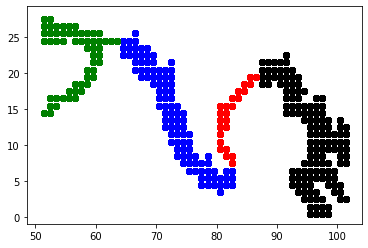

In [10]:
plt.scatter(lon_eBoB,lat_eBoB,color = 'k')
plt.scatter(lon_wBoB,lat_wBoB,color = 'r')
plt.scatter(lon_eAS,lat_eAS,color = 'b')
plt.scatter(lon_wAS,lat_wAS,color = 'g')



# SAVE

In [11]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:           (lat: 35, lon: 55, month: 12, month_eAS: 1200, month_eBoB: 1632, month_wAS: 672, month_wBoB: 288)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat               (lat) float32 -1.5 -0.5 0.5 1.5 ... 29.5 30.5 31.5 32.5
  * lon               (lon) float32 48.5 49.5 50.5 51.5 ... 100.5 101.5 102.5
  * month_wAS         (month_wAS) float64 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0
  * month_eAS         (month_eAS) float64 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0
  * month_wBoB        (month_wBoB) float64 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0
  * month_eBoB        (month_eBoB) float64 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0
Data variables:
    mon_sla_mon_clim  (month, lat, lon) float64 nan nan nan nan ... nan nan nan
    lat_wAS           (month_wAS) float64 14.5 14.5 15.5 15.5 ... 26.5 27.5 27.5
    lon_wAS           (month_wAS) float64 51.5 52.5 52.5 53.5 ... 56.5 51.5 52.5
    lat_eAS           (month_eAS) float64 4.5 4.5 5.5 5.5 ... 5